In [1]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../helper_functions')

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_rb_defense_headers
from get_df import fantasy_points, get_running_back_df, all_individual_stats

import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import patsy
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# df_all_running_backs_2019 = all_position_stats('2019','rushing', 37)
# df_all_running_backs_2019.columns = all_rb_defense_headers('2019','rushing')
# df_all_running_backs_2019.to_pickle("../pickled/df_all_running_backs_2019.pkl")

# # Pickling
# df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']] = df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']].apply(pd.to_numeric)
# df_all_running_backs_2019 = df_all_running_backs_2019[(df_all_running_backs_2019.Pos != 'QB')]
df_all_running_backs_2019 = pd.read_pickle("../pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019


Link                  Player   Tm  \
Derrick Henry         /players/H/HenrDe00.htm         Derrick Henry *  TEN   
Ezekiel Elliott       /players/E/ElliEz00.htm        Ezekiel Elliott*  DAL   
Nick Chubb            /players/C/ChubNi00.htm             Nick Chubb*  CLE   
Christian McCaffrey   /players/M/McCaCh01.htm  Christian McCaffrey *+  CAR   
Chris Carson          /players/C/CarsCh00.htm            Chris Carson  SEA   
Joe Mixon             /players/M/MixoJo00.htm               Joe Mixon  CIN   
Leonard Fournette     /players/F/FourLe00.htm      Leonard Fournette   JAX   
Dalvin Cook           /players/C/CookDa01.htm            Dalvin Cook*  MIN   
Marlon Mack           /players/M/MackMa00.htm             Marlon Mack  IND   
Sony Michel           /players/M/MichSo00.htm             Sony Michel  NWE   
Le'Veon Bell          /players/B/BellLe00.htm            Le'Veon Bell  NYJ   
Carlos Hyde           /players/H/HydeCa00.htm             Carlos Hyde  HOU   
Josh Jacobs           /players/J/JacoJo01.htm             Josh Jacobs  OAK   
David Montgomery      /players/M/MontDa01.htm        David Montgomery  CHI   
Aaron Jones           /players/J/JoneAa00.htm             Aaron Jones  GNB   
Phillip Lindsay       /players/L/LindPh00.htm         Phillip Lindsay  DEN   
Todd Gurley           /players/G/GurlTo01.htm             Todd Gurley  LAR   
Saquon Barkley        /players/B/BarkSa00.htm          Saquon Barkley  NYG   
Adrian Peterson       /players/P/PeteAd01.htm         Adrian Peterson  WAS   
Mark Ingram           /players/I/IngrMa01.htm            Mark Ingram*  BAL   
Devonta Freeman       /players/F/FreeDe00.htm        Devonta Freeman   ATL   
Miles Sanders         /players/S/SandMi01.htm          Miles Sanders   PHI   
Lamar Jackson         /players/J/JackLa00.htm         Lamar Jackson*+  BAL   
Ronald Jones II       /players/J/JoneRo01.htm         Ronald Jones II  TAM   
Alvin Kamara          /players/K/KamaAl00.htm           Alvin Kamara*  NOR   
Kenyan Drake          /players/D/DrakKe00.htm            Kenyan Drake  2TM   
Frank Gore            /players/G/GoreFr00.htm              Frank Gore  BUF   
Melvin Gordon         /players/G/GordMe00.htm           Melvin Gordon  LAC   
Peyton Barber         /players/B/BarbPe01.htm           Peyton Barber  TAM   
Devin Singletary      /players/S/SingDe00.htm        Devin Singletary  BUF   
Latavius Murray       /players/M/MurrLa00.htm         Latavius Murray  NOR   
Tevin Coleman         /players/C/ColeTe01.htm           Tevin Coleman  SFO   
Raheem Mostert        /players/M/MostRa00.htm          Raheem Mostert  SFO   
Gus Edwards           /players/E/EdwaGu00.htm            Gus Edwards   BAL   
Austin Ekeler         /players/E/EkelAu00.htm           Austin Ekeler  LAC   
Royce Freeman         /players/F/FreeRo00.htm           Royce Freeman  DEN   
Matt Breida           /players/B/BreiMa00.htm             Matt Breida  SFO   

                     Age Pos   G  GS  Att   Yds  TD  1D Lng  Y/A    Y/G Fmb  
Derrick Henry         25  RB  15  15  303  1540  16  73  74  5.1  102.7   5  
Ezekiel Elliott       24  RB  16  16  301  1357  12  78  33  4.5   84.8   3  
Nick Chubb            24  RB  16  16  298  1494   8  62  88  5.0   93.4   3  
Christian McCaffrey   23  RB  16  16  287  1387  15  57  84  4.8   86.7   1  
Chris Carson          25  RB  15  15  278  1230   7  75  59  4.4   82.0   7  
Joe Mixon             23  RB  16  15  278  1137   5  56  41  4.1   71.1   0  
Leonard Fournette     24  RB  15  15  265  1152   3  55  81  4.3   76.8   1  
Dalvin Cook           24  RB  14  14  250  1135  13  60  75  4.5   81.1   4  
Marlon Mack           23  RB  14  12  247  1091   8  67  63  4.4   77.9   0  
Sony Michel           24  RB  16  14  247   912   7  55  26  3.7   57.0   2  
Le'Veon Bell          27  RB  15  15  245   789   3  36  19  3.2   52.6   1  
Carlos Hyde           29  RB  16  14  245  1070   6  55  58  4.4   66.9   4  
Josh Jacobs           21  RB  13  13  242  1150   7  53  51  4

In [3]:
# all_running_backs_2019 = all_individual_stats(get_running_back_df, df_all_running_backs_2019, '2019')
# all_running_backs_2019.to_pickle("../pickled/all_running_backs_2019.pkl")

all_running_backs_2019 = pd.read_pickle("../pickled/all_running_backs_2019.pkl")
all_running_backs_2019

index            Name       Date  Game Team  Carries  Rush_Yards  \
0        0  Derrick Henry  2019-09-08     1  TEN     19.0        84.0   
1        1  Derrick Henry  2019-09-15     2  TEN     15.0        82.0   
2        2  Derrick Henry  2019-09-19     3  TEN     17.0        44.0   
3        3  Derrick Henry  2019-09-29     4  TEN     27.0       100.0   
4        4  Derrick Henry  2019-10-06     5  TEN     20.0        78.0   
..     ...             ...        ...   ...  ...      ...         ...   
513      7     Matt Breida 2019-10-31     8  SFO     15.0        78.0   
514      8     Matt Breida 2019-11-11     9  SFO     10.0        18.0   
515      9     Matt Breida 2019-12-08    13  SFO      6.0        54.0   
516     10     Matt Breida 2019-12-15    14  SFO      4.0        11.0   
517     11     Matt Breida 2019-12-21    15  SFO      NaN         NaN   

     Yards_per_Carry  Rush_TD  Receptions  Receiving_Yards    Y/R  \
0               4.42      1.0         1.0             75.0  75.00   
1               5.47      1.0         2.0             12.0   6.00   
2               2.59      1.0         1.0              2.0   2.00   
3               3.70      0.0         1.0              8.0   8.00   
4               3.90      1.0         0.0              0.0          
..               ...      ...         ...              ...    ...   
513             5.20      0.0         2.0             14.0   7.00   
514             1.80      0.0         2.0              7.0   3.50   
515             9.00      0.0         1.0              4.0   4.00   
516             2.75      0.0         2.0              6.0   3.00   
517              NaN      NaN         NaN              NaN          

     Receiving_TD  
0             1.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
..            ...  
513           0.0  
514           0.0  
515           0.0  
516           0.0  
517           NaN  

[518 rows x 13 columns]

In [4]:
# all_running_backs_fantasy_2019 = all_individual_stats(fantasy_points, df_all_running_backs_2019, '2019')
# all_running_backs_fantasy_2019.to_pickle("../pickled/all_running_backs_fantasy_2019.pkl")

all_running_backs_fantasy_2019 = pd.read_pickle("../pickled/all_running_backs_fantasy_2019.pkl")
all_running_backs_fantasy_2019

index            Name  Fantasy_Points
0        1  Derrick Henry             15.4
1        2  Derrick Henry             10.6
2        3  Derrick Henry             10.8
3        4  Derrick Henry             13.8
4        5  Derrick Henry              3.3
..     ...             ...             ...
513      8     Matt Breida             2.5
514      9     Matt Breida             5.8
515     10     Matt Breida            -0.3
516     11     Matt Breida             NaN
517     12     Matt Breida             1.6

[518 rows x 3 columns]

In [139]:
df_rushing_fantasy_2019 = all_running_backs_2019.iloc[:,1:2]

df_rushing_fantasy_2019['Fantasy_Points'] = all_running_backs_fantasy_2019.iloc[:,-1:]

# df_rushing_fantasy_2019['Receptions'] = all_running_backs_2019.iloc[:, 9:10]*.5

df_rushing_fantasy_2019['Rush_Yards'] = all_running_backs_2019.iloc[:,6:7]/10
df_rushing_fantasy_2019['Receiving_Yards'] = all_running_backs_2019.iloc[:,10:11]/10

df_rushing_fantasy_2019['Rush_TD'] = all_running_backs_2019.iloc[:,8:9]*6
df_rushing_fantasy_2019['Receiving_TD'] = all_running_backs_2019.iloc[:,-1:]*6

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.dropna()

df_rushing_fantasy_points = df_rushing_fantasy_2019[['Fantasy_Points']]

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.groupby('Name').expanding().mean().reset_index()

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.sort_values('level_1').reset_index()

df_rushing_fantasy_2019['Fantasy_Points'] = df_rushing_fantasy_points.iloc[:,:1]

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.drop(['index','level_1'],axis=1)

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.dropna()

df_rushing_fantasy_2019.to_pickle("../pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = pd.read_pickle("../pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019

Name  Fantasy_Points  Rush_Yards  Receiving_Yards   Rush_TD  \
0    Derrick Henry             15.4    8.400000         7.500000  6.000000   
1    Derrick Henry             10.6    8.300000         4.350000  6.000000   
2    Derrick Henry             10.8    7.000000         2.966667  6.000000   
3    Derrick Henry             13.8    7.750000         2.425000  4.500000   
4    Derrick Henry              3.3    7.760000         1.940000  4.800000   
..              ...             ...         ...              ...       ...   
507     Matt Breida             8.8    6.850000         1.233333  1.000000   
508     Matt Breida            24.9    6.371429         1.271429  0.857143   
509     Matt Breida             6.3    6.550000         1.287500  0.750000   
510     Matt Breida             3.6    6.022222         1.222222  0.666667   
511     Matt Breida             5.0    5.960000         1.140000  0.600000   

     Receiving_TD  
0        6.000000  
1        3.000000  
2        2.000000  
3        1.500000  
4        1.200000  
..            ...  
507      1.000000  
508      0.857143  
509      0.750000  
510      0.666667  
511      0.600000  

[508 rows x 6 columns]

In [140]:
df_rushing_fantasy_2019.corr()

Fantasy_Points  Rush_Yards  Receiving_Yards   Rush_TD  \
Fantasy_Points         1.000000    0.168361         0.318196  0.305922   
Rush_Yards             0.168361    1.000000        -0.026976 -0.214586   
Receiving_Yards        0.318196   -0.026976         1.000000  0.686588   
Rush_TD                0.305922   -0.214586         0.686588  1.000000   
Receiving_TD           0.282557   -0.204367         0.640403  0.911730   

                 Receiving_TD  
Fantasy_Points       0.282557  
Rush_Yards          -0.204367  
Receiving_Yards      0.640403  
Rush_TD              0.911730  
Receiving_TD         1.000000

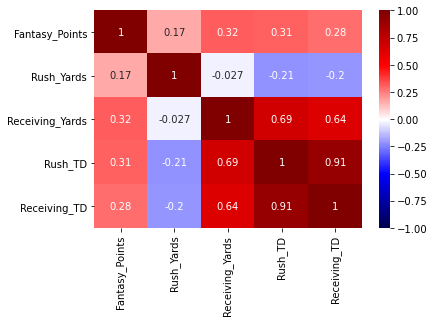

In [141]:
# example of a better corr matrix
# do this for all running backs, wide receivers, and quarterbacks
sns.heatmap(df_rushing_fantasy_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

<Figure size 1440x540 with 0 Axes>

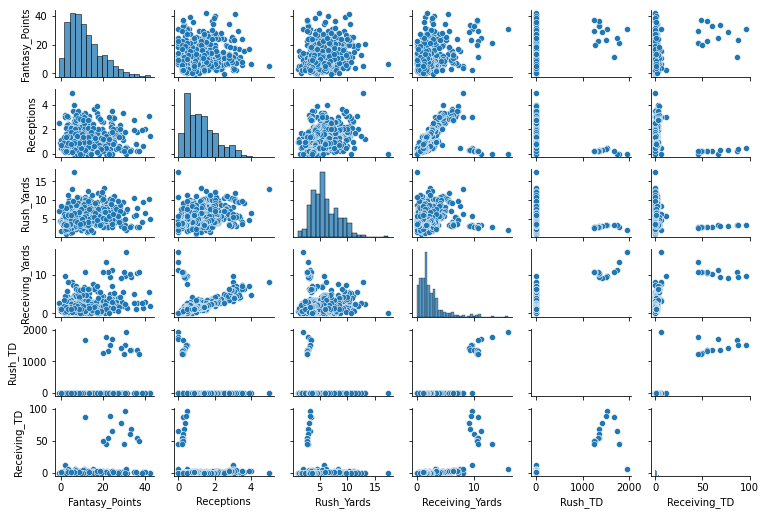

In [30]:
# do this for all running backs, wide receivers, and quarterbacks
plt.figure(figsize = [20,7.5])

sns.pairplot(df_rushing_fantasy_2019, height=1.2, aspect=1.5);

#### Cross-Validation For Model Selection

Demonstrates two typical workflows for using validation data to select models. It also demonstrates the use of some utility methods like generating **polynomial features**, converting **categorical features to "dummy variable"** binary columns, and **scaling features** when applying regularization.

**Contents Below**

> 1. Simple preprocessing and dummy variables
> 2. Basic validation method: Train/validation/test
> 3. Rigorous validation method: Cross-validation/test
> 4. Making CV less manual via scikit-learn

## 1. Preprocessing and Dummy Variables

In [142]:
pd.get_dummies(df_rushing_fantasy_2019['Name'])

Aaron Jones  Adrian Peterson  Alvin Kamara  Austin Ekeler  Carlos Hyde  \
0              0                0             0              0            0   
1              0                0             0              0            0   
2              0                0             0              0            0   
3              0                0             0              0            0   
4              0                0             0              0            0   
..           ...              ...           ...            ...          ...   
507            0                0             0              0            0   
508            0                0             0              0            0   
509            0                0             0              0            0   
510            0                0             0              0            0   
511            0                0             0              0            0   

     Chris Carson  Christian McCaffrey   Dalvin Cook  David Montgomery  \
0               0                     0            0                 0   
1               0                     0            0                 0   
2               0                     0            0                 0   
3               0                     0            0                 0   
4               0                     0            0                 0   
..            ...                   ...          ...               ...   
507             0                     0            0                 0   
508             0                     0            0                 0   
509             0                     0            0                 0   
510             0                     0            0                 0   
511             0                     0            0                 0   

     Derrick Henry   ...  Nick Chubb  Peyton Barber  Phillip Lindsay  \
0                 1  ...           0              0                0   
1                 1  ...           0              0                0   
2                 1  ...           0              0                0   
3                 1  ...           0              0                0   
4                 1  ...           0              0                0   
..              ...  ...         ...            ...              ...   
507               0  ...           0              0                0   
508               0  ...           0              0                0   
509               0  ...           0              0                0   
510               0  ...           0              0                0   
511               0  ...           0              0                0   

     Raheem Mostert  Ronald Jones II  Royce Freeman  Saquon Barkley  \
0                 0                0              0               0   
1                 0                0              0               0   
2                 0                0              0               0   
3                 0                0              0               0   
4                 0                0              0               0   
..              ...              ...            ...             ...   
507               0                0              0               0   
508               0                0              0               0   
509               0                0              0               0   
510               0                0              0               0   
511               0                0              0               0   

     Sony Michel  Tevin Coleman  Todd Gurley  
0              0              0            0  
1              0              0            0  
2              0              0            0  
3              0              0            0  
4              0              0            0  
..           ...            ...          ...  
507            0              0            0  
508            0              0            0  
509            0          

In [143]:
df_rushing_fantasy_2019 = pd.get_dummies(df_rushing_fantasy_2019)
df_rushing_fantasy_2019.head(20)

Fantasy_Points  Rush_Yards  Receiving_Yards   Rush_TD  Receiving_TD  \
0             15.4    8.400000         7.500000  6.000000      6.000000   
1             10.6    8.300000         4.350000  6.000000      3.000000   
2             10.8    7.000000         2.966667  6.000000      2.000000   
3             13.8    7.750000         2.425000  4.500000      1.500000   
4              3.3    7.760000         1.940000  4.800000      1.200000   
5             16.8    6.933333         1.700000  4.000000      1.000000   
6              6.3    7.228571         1.714286  4.285714      0.857143   
7             21.9    7.262500         1.600000  3.750000      0.750000   
8             31.1    7.155556         1.822222  4.000000      1.333333   
9             27.5    8.320000         1.670000  4.800000      1.200000   
10            20.6    9.009091         1.663636  5.454545      1.090909   
11            22.9    9.500000         1.666667  5.500000      1.000000   
12             8.6    9.561538         1.584615  6.000000      0.923077   
13            39.1    9.492857         1.471429  5.571429      0.857143   
14            18.0    5.300000         1.000000  6.000000      0.000000   
15            13.9    8.200000         0.950000  6.000000      0.000000   
16            10.5    9.633333         1.100000  4.000000      0.000000   
17            15.1    8.100000         1.575000  4.500000      0.000000   
18            21.3    7.720000         1.840000  4.800000      0.000000   
19            20.7    8.183333         2.333333  5.000000      0.000000   

    Name_Aaron Jones  Name_Adrian Peterson  Name_Alvin Kamara  \
0                  0                     0                  0   
1                  0                     0                  0   
2                  0                     0                  0   
3                  0                     0                  0   
4                  0                     0                  0   
5                  0                     0                  0   
6                  0                     0                  0   
7                  0                     0                  0   
8                  0                     0                  0   
9                  0                     0                  0   
10                 0                     0                  0   
11                 0                     0                  0   
12                 0                     0                  0   
13                 0                     0                  0   
14                 0                     0                  0   
15                 0                     0                  0   
16                 0                     0                  0   
17                 0                     0                  0   
18                 0                     0                  0   
19                 0                     0                  0   

    Name_Austin Ekeler  Name_Carlos Hyde  ...  Name_Nick Chubb  \
0                    0                 0  ...                0   
1                    0                 0  ...                0   
2                    0                 0  ...                0   
3                    0                 0  ...                0   
4                    0                 0  ...                0   
5                    0                 0  ...                0   
6                    0                 0  ...                0   
7                    0                 0  ...                0   
8                    0                 0  ...                0   
9                    0                 0  ...                0   
10                   0                 0  ...                0   
11                   0                 0  ...                0   
12                   0                 0  ...                0   
13                   0                 0  ...                0   
14                   0                 0  ...                0   
15    

## 2. Simple Validation Method: Train / Validation / Test

Break data into 3 portions: 60% for training, 20% for validation (used to select the model), 20% for final testing evaluation.

In [144]:
X, y = df_rushing_fantasy_2019.drop('Fantasy_Points',axis=1), df_rushing_fantasy_2019['Fantasy_Points']

# # hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) #why does the random state change results?
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [145]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

Model Setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

Also, we need to get **polynomial features** for the poly model

In [146]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_las = Lasso(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

# X_train_poly = poly.fit_transform(X_train)
# X_val_poly = poly.transform(X_val)
# X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

<AxesSubplot:>

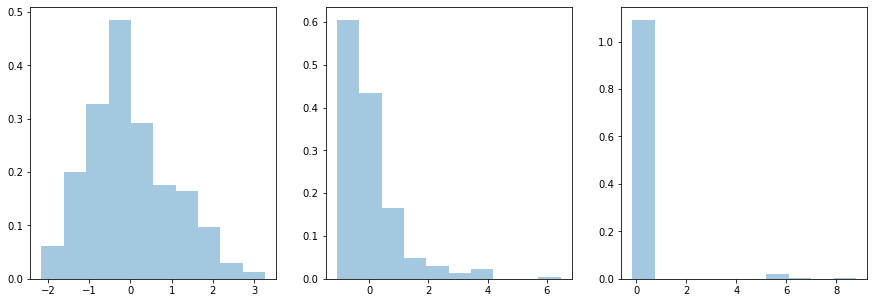

In [147]:
# Plot histograms of a few transformed variables
# Note that they seem to have means of 0 and stddevs of 1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(X_train_scaled[:, 0], label='feature 1', ax=axes[0], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 1], label='feature 2', ax=axes[1], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 2], label='feature 3', ax=axes[2], kde=False, bins=10, norm_hist=True)


In [148]:
lm.fit(X_train, y_train)
print(f'Linear Regression Train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression Val R^2: {lm.score(X_val, y_val):.3f}')
print(f'Linear Regression Test R^2: {lm.score(X_test, y_test):.3f}\n')

lm_las.fit(X_train_scaled, y_train)

print(f'Lasso Regression Train R^2: {lm_las.score(X_train, y_train):.3f}')
print(f'Lasso Regression Val Scaled R^2: {lm_las.score(X_val_scaled, y_val):.3f}')
print(f'Lasso Regression Test R^2: {lm_las.score(X_test, y_test):.3f}\n')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression Train R^2: {lm_reg.score(X_train, y_train):.3f}')
print(f'Ridge Regression Val Scaled R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression Test R^2: {lm_reg.score(X_test, y_test):.3f}\n')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression Train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
print(f'Degree 2 polynomial regression Val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression Test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression Train R^2: 0.302
Linear Regression Val R^2: 0.011
Linear Regression Test R^2: 0.235

Lasso Regression Train R^2: -0.130
Lasso Regression Val Scaled R^2: 0.082
Lasso Regression Test R^2: 0.034

Ridge Regression Train R^2: -34.433
Ridge Regression Val Scaled R^2: 0.007
Ridge Regression Test R^2: -62.618

Degree 2 polynomial regression Train R^2: 0.704
Degree 2 polynomial regression Val R^2: -661.200
Degree 2 polynomial regression Test R^2: -460.729


Negative R^2 equals severe overfitting! 

So having run this validation step, we see that the evidence points to Lasso regression being the best model. So our validation process lets us **select** that choice of model, and as our final step we retrain it on the entire chunk of train/val data and see how it does on test data:  

In [149]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.254


## 3. Rigorous Validation Method: Cross-Validation / Test

Break data into 2 portions: 80% for a cross-validated training process, and 20% for final testing evaluation. 

Remember that the idea of CV is to make efficient use of the data available to us (using 80% instead of 60% above), while also performing multiple validation checks. For k-fold CV, we come up with k train/validation splits of the whole chunk of data, in such a way that **each observation is in the validation set exactly 1 time**. 

For simplicity we'll focus on linear regression and ridge regression (we also can feel pretty comfortable throwing out the full degree 2 polynomial regression based on the poor results above!) As we loop through our CV folds, we will train and validate both models and collect the results to compare at the end. Note that we scale the training features within the CV loop.

In [150]:
X, y = df_rushing_fantasy_2019.drop('Fantasy_Points',axis=1), df_rushing_fantasy_2019['Fantasy_Points']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [151]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_train_r2s, cv_lm_val_r2s, cv_lm_las_r2s, cv_lm_reg_r2s, rmses = [], [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_las = Lasso(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_train_r2s.append(lm.score(X_train, y_train))
    cv_lm_val_r2s.append(lm.score(X_val, y_val))

    
    lm_rmse = mean_squared_error(y_val, lm.predict(X_val), squared=False)

    rmses.append(lm_rmse)

    # setup for ridge and lasso 
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #lass with feature scaling 
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_r2s.append(lm_las.score(X_val_scaled, y_val))

    #ridge with feature scaling
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_val_r2s)
print('Lasso scores: ', cv_lm_las_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Lasso mean cv r^2: {np.mean(cv_lm_las_r2s):.3f} +- {np.std(cv_lm_las_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lm_train_r2s):.3f} +- {np.std(cv_lm_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lm_val_r2s):.3f} +- {np.std(cv_lm_val_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [0.1442892855357859, 0.16347335558449982, -0.07332166751325087, -0.08283602920323929, 0.020196580290295918]
Lasso scores:  [0.12804675080344252, 0.13222589868847578, 0.0862083661656825, 0.054160564126226496, 0.06259123759139396] 

Ridge scores:  [0.14314759449014813, 0.15815618844092183, -0.062190290299460216, -0.0816841206384249, 0.022991074917932175] 

Lasso mean cv r^2: 0.093 +- 0.032
Ridge mean cv r^2: 0.036 +- 0.100
Simple mean cv r^2 (TRAIN): 0.300 +- 0.020
Simple mean cv r^2 (VAL): 0.034 +- 0.104
Simple mean RMSE: 7.994 +- 0.681


The plot thickens! Our simple validation method above pointed to simple linear regression being better than lasso and ridge, but k-fold shows the opposite. The lasso model appears to be both better on average and has less varying results.

**Since k-fold is more reliable than a single validation set, we select the lasso regression model**. This shows the dangers of relying on simple validation methods, especially when our sample sizes are small.

In [164]:
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Higher alpha = strong regularization strength 
lm_las = Lasso(alpha=0.8119844993184013)
lm_reg = Ridge(alpha=100)

lm_las.fit(X_scaled,y)
lm_reg.fit(X_scaled,y)

print(f'Lasso Regression test R^2: {lm_las.score(X_test_scaled, y_test):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Lasso Regression test R^2: 0.172
Ridge Regression test R^2: 0.194


In [165]:
list(zip(df_rushing_fantasy_2019.columns[1:],lm_las.coef_[:4]))

[('Rush_Yards', 0.7189955273039648),
 ('Receiving_Yards', 0.214470780783332),
 ('Rush_TD', 0.0),
 ('Receiving_TD', 0.0)]

In [166]:
list(zip(df_rushing_fantasy_2019.columns[1:5],lm_reg.coef_[:4]))

[('Rush_Yards', 0.5482321274749855),
 ('Receiving_Yards', 0.15357528014924918),
 ('Rush_TD', 0.6937144319021593),
 ('Receiving_TD', 0.6713724666871945)]

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_ (ish): will never fully discard features

As always, you have to validate to choose between the two. If the mapping from features to target truly depends on only a few key features, LASSO should outperform. If instead the target actually depends on many features (even if only a little dependent), Ridge should work better.  

In [167]:
selected_columns = list(df_rushing_fantasy_2019.columns[1:5])
selected_columns

['Rush_Yards', 'Receiving_Yards', 'Rush_TD', 'Receiving_TD']

In [168]:
# test_set_pred = lm_las.predict(X_test.loc[:,selected_columns])
test_set_pred = lm_las.predict(X_test)

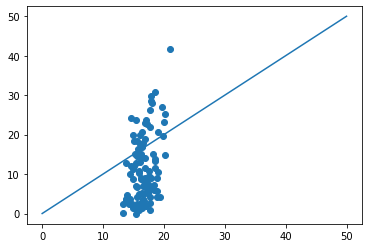

In [169]:
plt.scatter(test_set_pred, y_test, alpha=1)
plt.plot(np.linspace(0,50,50), np.linspace(0,50,50))

In [170]:
#r-squared
r2_score(y_test, test_set_pred)

-0.24157459615404564

In [171]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

8.090133260326223

## 4. Tuning Regularization Strength via Validation

Here we will attempt to find the "best" value of the regularization strength alpha for this feature and target set and the LASSO model. We'll use simple validation (single train/valid split) as our model selection method.

We will first decide on a vector of "candidate" alpha values.  Then, for each candidate value, we run the following steps:

> 1. Fit a LASSO model on the training data
> 2. Using the newly trained model, make predictions on the validation data
> 3. Run evaluation metrics on validation

Then we plot how the errors change for the different values of alpha, and see where alpha minimizes our error metric on the validation data. This value of alpha is the one we would select for our final model.

In [172]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    # pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    pipe.fit(X_train, y_train)
    
    # val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

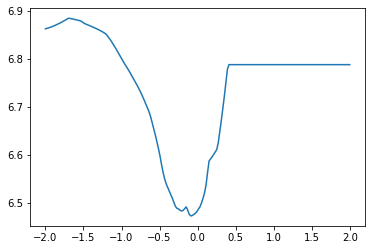

In [173]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [174]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

6.472978405844589

In [175]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.8119844993184013

---
**Regularization Tuning Exercise**: 

Repeat the model selection workflow above (simple validation), but using a ridge model instead of a LASSO model. Based on the evidence you gather, do you think that a ridge or LASSO model has better predictive power on this dataset?

---

In [176]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('Ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    # pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    pipe.fit(X_train, y_train)
    
    # val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

In [177]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

6.7104794614799275

In [178]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

100.0

## LassoCV for Running Backs

In [179]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_las_CV = LassoCV(alphas = alphavec, cv=5)
lm_las_CV.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [180]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lm_las_CV.alpha_

0.12173827277396614

In [181]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
# list(zip(X_train.columns, lm_las_CV.coef_))
list(zip(X_train, lm_las_CV.coef_))

[(array([10.7,  0. , 12. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]),
  0.6757784272998122),
 (array([4.2       , 1.61666667, 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]),
  0.07189113128160751),
 (array([ 8.5,  2.8, 12. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. 

In [182]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

8.090133260326223

In [183]:
r2_score(y_test, test_set_pred)

-0.24157459615404564

In [184]:
# L = LassoCV()
# s = StandardScaler(with_mean=False)
# X_train_poly_scaled = s.fit_transform(X_train_poly)
# L.fit(X_train_poly_scaled, y_train)

# print("Training Score: ", L.score(X_train_poly_scaled, y_train), "Test Score: " , L.score(s.transform(p.transform(X_test)),y_test))

In [185]:
# R = RidgeCV()
# R.fit(x_train_poly_scaled, y_train)

# print("Training Score: ", R.score(x_train_poly_scaled, y_train), "Test Score: " , R.score(s.transform(p.transform(X_test)),y_test))

## 3. Standard-scaling Features (a must for regularization!)

One issue with Regularized Linear Regression is that the "size" of a coefficient may be more reflective of the units or scale of the associated variable than the actual power of the relationship.  For example, if a distance is measured in millimeters it will have a larger coefficient than if it is measured in miles.  For this reason, best practice is to "standardize" the variables prior to running a regularized regression.  Standardizing means subtracting off each feature column's mean and then dividing by its standard deviation so that the resulting variable has mean 0 and standard deviation 1. This ensures that the variables are penalized fairly with respect to one another.

We demonstrate how to do this below.

## Linear Regression Modeling

Text(0, 0.5, 'Actual Values')

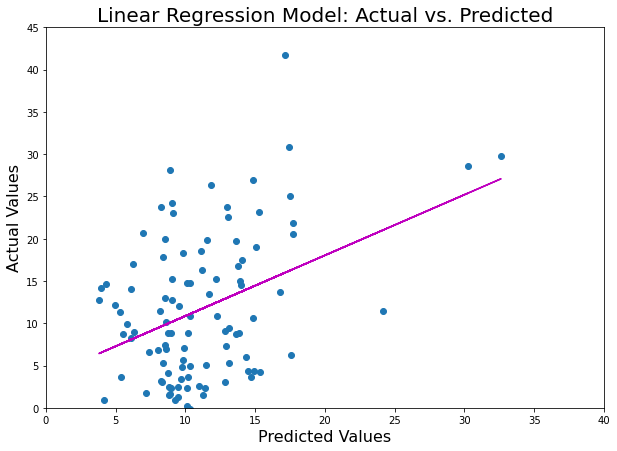

In [186]:
lm_predict = lm.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_predict, y_test)

z = np.polyfit(lm_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_predict, p(lm_predict), "m-")

plt.xlim(0,40)
plt.ylim(0,45)

plt.title('Linear Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Ridge Regression Modeling

Text(0, 0.5, 'Actual Values')

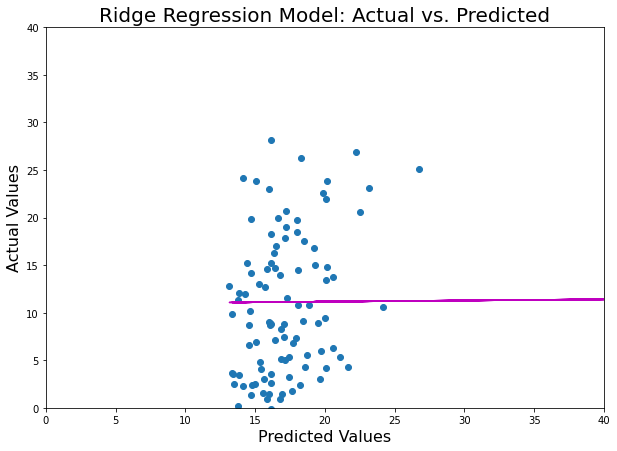

In [187]:
lm_reg_predict = lm_reg.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_reg_predict, y_test)

z = np.polyfit(lm_reg_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_reg_predict, p(lm_reg_predict), "m-")

plt.xlim(0,40)
plt.ylim(0,40)

plt.title('Ridge Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

## Lasso Regression

Text(0, 0.5, 'Actual Values')

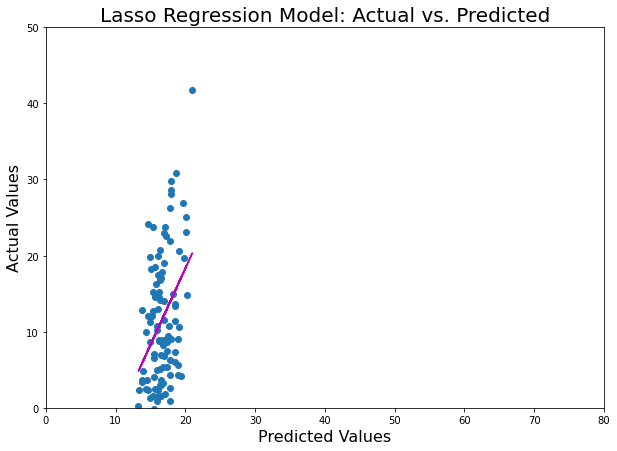

In [188]:
lm_las_predict = lm_las.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_las_predict, y_test)

z = np.polyfit(lm_las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_las_predict, p(lm_las_predict), "m-")

plt.xlim(0,80)
plt.ylim(0,50)

plt.title('Lasso Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

In [189]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Receptions + Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

PatsyError: Error evaluating factor: NameError: name 'Receptions' is not defined
    Fantasy_Points ~ Receptions + Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD
                     ^^^^^^^^^^

In [191]:
# Define the model
lm1 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     24.51
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.50e-18
Time:                        17:35:56   Log-Likelihood:                -1747.6
No. Observations:                 508   AIC:                             3505.
Df Residuals:                     503   BIC:                             3526.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3700      1.003      5.352      0.000       3.399       7.341
Rush_Yards          0.7955      0.149      5.336      0.000       0.503       1.088
Receiving_Yards     0.5967      0.223      2.676      0.008       0.159       1.035
Rush_TD             0.0078      0.004      2.186      0.029       0.001       0.015
Receiving_TD        0.0158      0.078      0.203      0.839      -0.137       0.169
==============================================================================
Omnibus:                       80.891   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.777
Skew:                           1.027   Prob(JB):                     1.32e-27
Kurtosis:                       4.275   Cond. No.                         747.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
# Define the model
lm2 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     24.51
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.50e-18
Time:                        17:36:03   Log-Likelihood:                -1747.6
No. Observations:                 508   AIC:                             3505.
Df Residuals:                     503   BIC:                             3526.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3700      1.003      5.352      0.000       3.399       7.341
Rush_Yards          0.7955      0.149      5.336      0.000       0.503       1.088
Receiving_Yards     0.5967      0.223      2.676      0.008       0.159       1.035
Rush_TD             0.0078      0.004      2.186      0.029       0.001       0.015
Receiving_TD        0.0158      0.078      0.203      0.839      -0.137       0.169
==============================================================================
Omnibus:                       80.891   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.777
Skew:                           1.027   Prob(JB):                     1.32e-27
Kurtosis:                       4.275   Cond. No.                         747.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Define the model
lm3 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit3 = lm3.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     32.72
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           2.44e-19
Time:                        15:30:04   Log-Likelihood:                -1747.6
No. Observations:                 508   AIC:                             3503.
Df Residuals:                     504   BIC:                             3520.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3796      1.001      5.373      0.000       3.412       7.347
Rush_Yards          0.0795      0.015      5.338      0.000       0.050       0.109
Receiving_Yards     0.0599      0.022      2.693      0.007       0.016       0.104
Rush_TD             0.0505      0.012      4.282      0.000       0.027       0.074
==============================================================================
Omnibus:                       80.879   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.585
Skew:                           1.028   Prob(JB):                     1.46e-27
Kurtosis:                       4.268   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

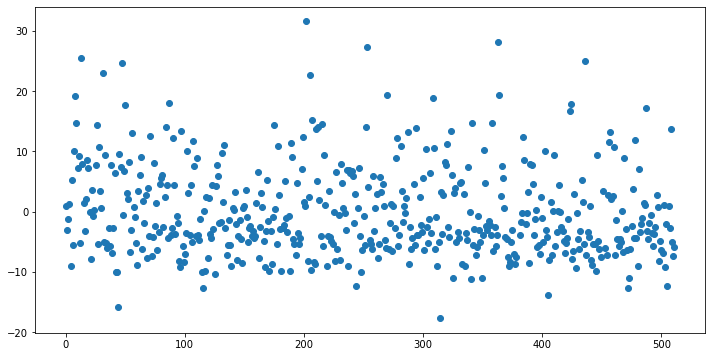

In [26]:
#Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random. I'm not sure if the below looks too random. It seems to be between -5, so what does that mean? May be missing actual functional dependency underlying the data. This data may not be linear but let's keep going. 
fit1.resid.plot(style='o',figsize=(12,6))

<AxesSubplot:>

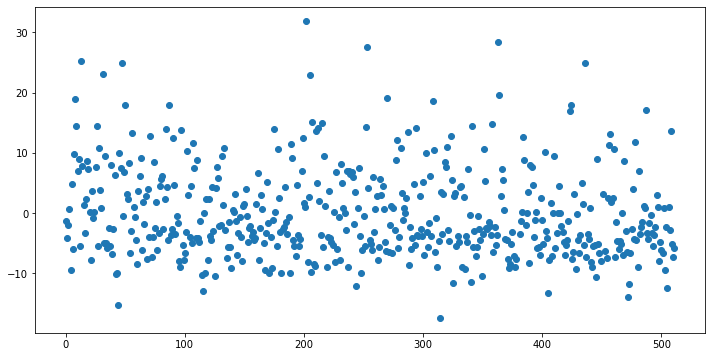

In [27]:
fit2.resid.plot(style='o',figsize=(12,6))

<AxesSubplot:>

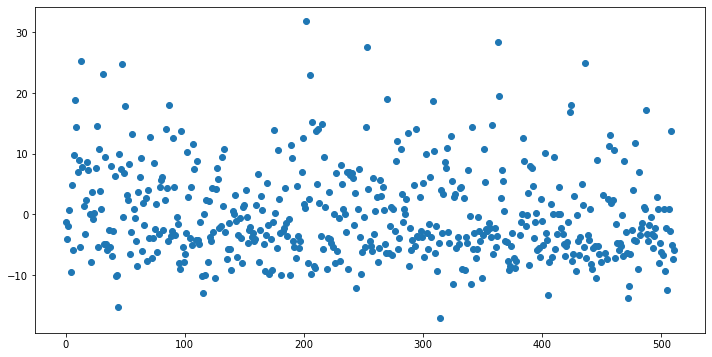

In [28]:
fit3.resid.plot(style='o',figsize=(12,6))

In [31]:
# fig, ax = plt.subplots()

# ax.scatter(df_rushing_fantasy_2019['Rush_Yards'], df_rushing_fantasy_2019['Fantasy_Points'], alpha=0.01)

# x = np.linspace(0,1,num = 10)
# ax.scatter(x, lr.predict(x.reshape(-1,1)))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_rushing_fantasy_2019[['Rush_Yards']], df_rushing_fantasy_2019['Fantasy_Points'], test_size=0.33, random_state=200)

X_train = np.array(X_train.values.tolist())
X_test = np.array(X_test.values.tolist())

# Make predictions using the testing set
y_pred = lm.predict(X_test)

# The coefficients
print('Coefficients: \n', m.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

# # Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 42 is different from 1)

In [30]:
# fig, ax = plt.subplots()

# ax.scatter = (df_rushing_fantasy_2019['Fantasy_Points'],df_rushing_fantasy_2019['Rush_Yards_Points'])

# x = np.linspace(0,1, num=10)
# ax.scatter(x, lr.predict(x.reshape(-1,1)))

In [18]:
YC_derrick_henry_rb_2019_array = np.array(derrick_henry_rb_2019_trim[['Yards_per_Carry']].values.tolist())

NameError: name 'derrick_henry_rb_2019_trim' is not defined

In [47]:
YC_derrick_henry[:-4]

array([[4.42],
       [5.47],
       [2.59],
       [3.7 ],
       [3.9 ],
       [1.87],
       [4.09],
       [4.69],
       [4.85],
       [8.17],
       [8.37]])

In [48]:
YC_derrick_henry[-4:]

array([[5.73],
       [5.72],
       [4.1 ],
       [6.59]])

Coefficients: 
 [21.07662871]
Mean squared error: 2074.19
Coefficient of determination: 0.12


[&lt;matplotlib.lines.Line2D at 0x14c1b48e0&gt;]

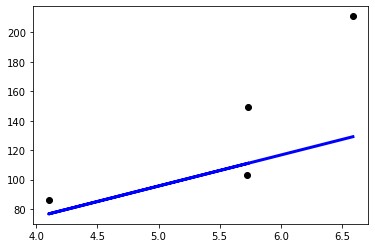

In [46]:
# Use only one feature: Carries/Game for Running Back
# X-Variable
YC_derrick_henry = YC_derrick_henry_rb_2019_array

# Split the data into training/testing sets
YC_derrick_henry_train = YC_derrick_henry[:-4]
YC_derrick_henry_test = YC_derrick_henry[-4:]

# Target Variable: Rushing Yards/Game for Running Back
# Y-Variable
yards_derrick_henry = derrick_henry_rb_2019_trim['Total_Yards']

# Split the targets into training/testing sets
yards_derrick_henry_train = yards_derrick_henry[:-4]
yards_derrick_henry_test = yards_derrick_henry[-4:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(YC_derrick_henry_train, yards_derrick_henry_train)

# Make predictions using the testing set
yards_derrick_henry_pred = regr.predict(YC_derrick_henry_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(yards_derrick_henry_test, yards_derrick_henry_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(yards_derrick_henry_test, yards_derrick_henry_pred))

# # Plot outputs
plt.scatter(YC_derrick_henry_test, yards_derrick_henry_test,  color='black')
plt.plot(YC_derrick_henry_test, yards_derrick_henry_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

# Polynomial Regression

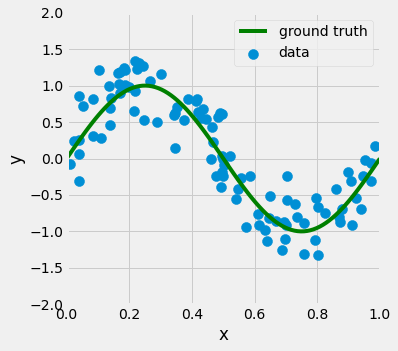

In [32]:
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

# Seed random number generator to ensure everyone has random results
np.random.seed(9)

# Function that returns sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
# Returns 100 evenly spaced numbers from 0 to 1
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
# Generate the x values from the random uniform distribution between 0 and 1
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1);
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X, y, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend();

In [136]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

Generate pipeline for a 3rd degree polynomial and try plotting function. 
- Use PolynomialFeatures(3) to create a generator of 3rd degree polynomials
- Feed this generator to make_pipeline along with a LinearRegression object to tell it to string together these operations when given a new set of input predictor variables.  This results in a new model object that has the same `fit()`, `score()`, `predict()`, etc functions
- Call `fit()` on our new object to fit a 3rd degree polynomial regression
- Send the result to our plotting function to view the results

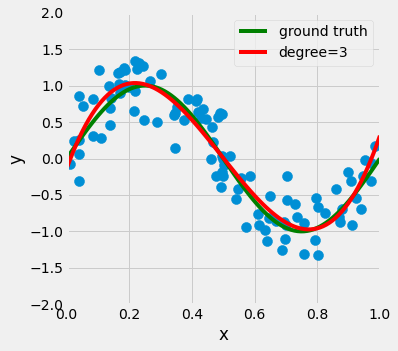

In [137]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 3

# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)